In [23]:
import numpy as np
import scipy as sp
import sklearn
import sklearn.linear_model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [24]:
np.random.seed(42)
torch.manual_seed(42);

In [25]:
# to zoom in the plot
# %matplotlib widget 

# Inverse dynamical model of a mechanical system

## Dataset

We consider the dataset available here: https://www.nonlinearbenchmark.org/benchmarks/emps. 

The test device is a single prismatic joint, which is modeled as a 1-DoF mechanical system of mass $M$. We apply a force $\tau(t)$ (N) and measure the joint position $q(t)$ (m). 
The applied force is actually measured up to an unknown constant bias $b$ (N). Moreover, friction forces $\tau_{f}(t)$ act on the system.

Newton's law suggests:
$$ M \ddot q(t) = \tau(t) - \tau_{f}(t) - b$$ 


In this notebook, we illustrate the inverse dynamical modeling of the system, namely the problem of reconstructiong $\tau(t)$ from $q(t)$ and (its derivatives). 

The original dataset contains measurements of $q(t)$ and $\tau(t)$ and is already split in a train and a test part. A few pre-processing steps have been performed in the notebook dataset_preproc.ipynb.
For instance, $\dot q(t)$ and $\ddot q(t)$ have been obtained through a careful numerical differentiation of $q(t)$. 

Let us first explore the data!

In [26]:
# Load data
data = sp.io.loadmat('EMPS.mat')
train_tau = data['train_tau'] # force (N)
train_q = data['train_q'] # position (m)
train_dq = data['train_dq'] # velocity (m/s)
train_ddq = data['train_ddq'] # train acceleration (m/s^2)
test_tau = data['test_tau']
test_q = data['test_q']
test_dq = data['test_dq']
test_ddq = data['test_ddq']
ts = data['ts'][0, 0]

In [27]:
train_t = np.arange(0, len(train_q)) * ts
test_t = np.arange(0, len(test_q)) * ts
train_t.shape, test_t.shape

((24841,), (24841,))

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Lorenzo Bauce\AppData\Local\Temp\ipykernel_9756\570403681.py:8: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_title('train $\dot q$')
C:\Users\Lorenzo Bauce\AppData\Local\Temp\ipykernel_9756\570403681.py:11: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_title('train $\ddot q$')


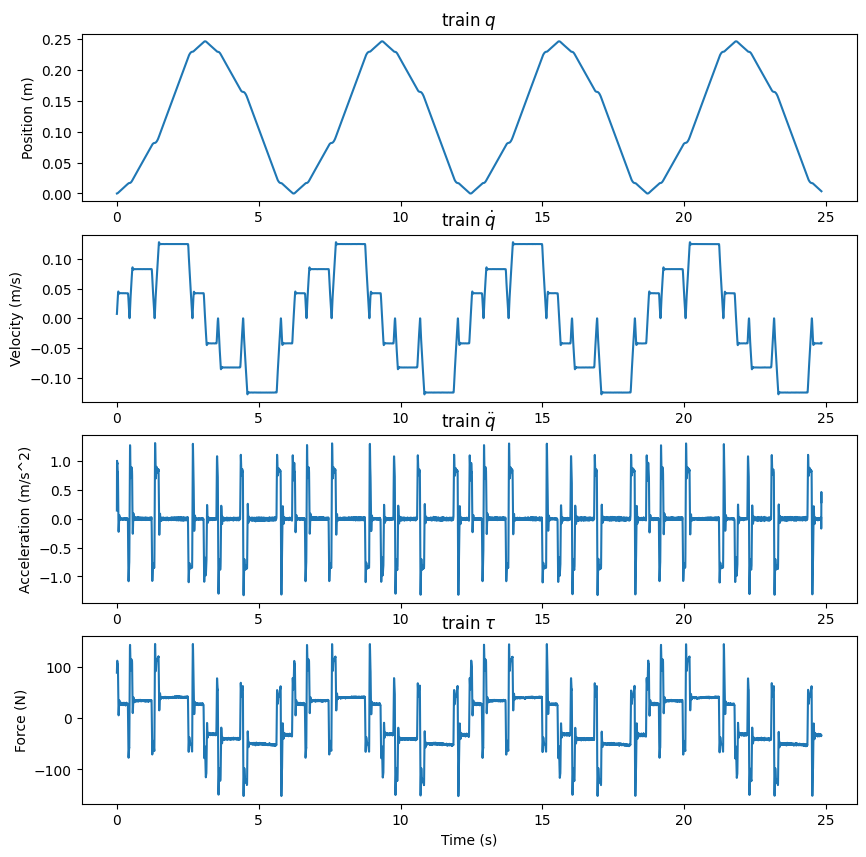

In [28]:
# Visualize data

fig, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].plot(train_t, train_q)
ax[0].set_title('train $q$')
ax[0].set_ylabel('Position (m)')
ax[1].plot(train_t, train_dq)
ax[1].set_title('train $\dot q$')
ax[1].set_ylabel('Velocity (m/s)')
ax[2].plot(train_t, train_ddq)
ax[2].set_title('train $\ddot q$')
ax[2].set_ylabel('Acceleration (m/s^2)')
ax[3].plot(train_t, train_tau)
ax[3].set_title(r'train $\tau$')
ax[3].set_ylabel('Force (N)')
ax[3].set_xlabel('Time (s)');

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Lorenzo Bauce\AppData\Local\Temp\ipykernel_9756\2627655565.py:6: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_title('test $\dot q$')
C:\Users\Lorenzo Bauce\AppData\Local\Temp\ipykernel_9756\2627655565.py:9: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_title('test $\ddot q$')


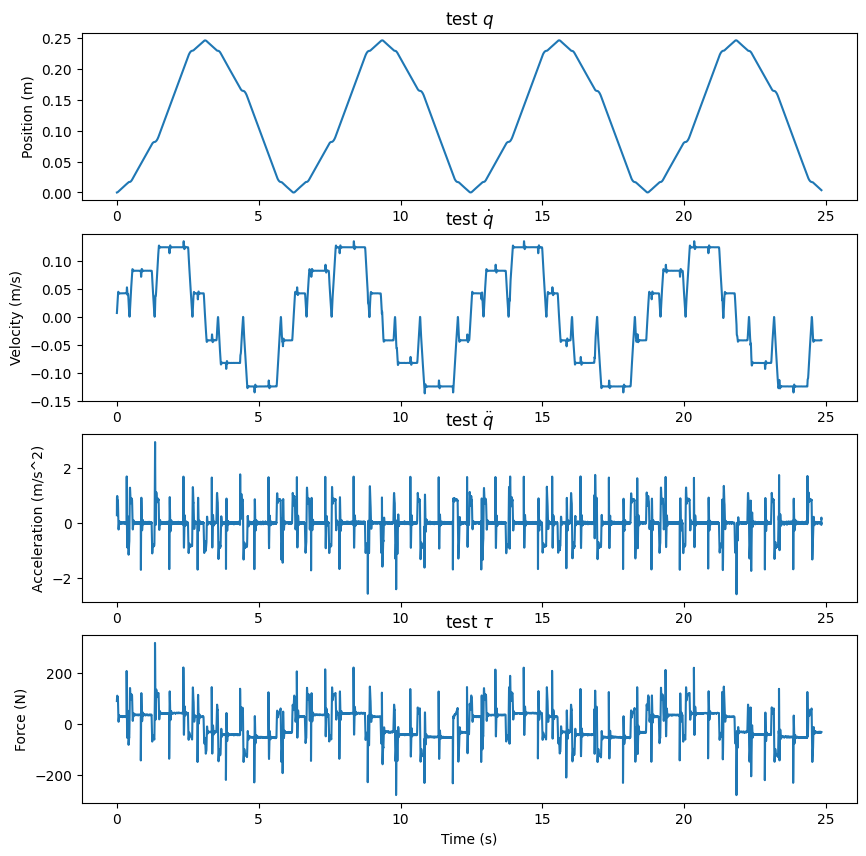

In [29]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].plot(test_t, test_q)
ax[0].set_title('test $q$')
ax[0].set_ylabel('Position (m)')
ax[1].plot(test_t, test_dq)
ax[1].set_title('test $\dot q$')
ax[1].set_ylabel('Velocity (m/s)')
ax[2].plot(test_t, test_ddq)
ax[2].set_title('test $\ddot q$')
ax[2].set_ylabel('Acceleration (m/s^2)')
ax[3].plot(test_t, test_tau)
ax[3].set_title(r'test $\tau$')
ax[3].set_ylabel('Force (N)')
ax[3].set_xlabel('Time (s)');

## Linear least-squares IDM

A very simple inverse dynamic model (IDM) for this system is:

$$\tau(t) = M\ddot q(t) + F_v \dot q(t) + b$$

which assumes a friction model:
$$ \tau_{f} = -F_v \dot q(t)$$

The free parameters are:
* $M$: system mass
* $F_v$: viscous friction
* $b$: an additional constant, which takes into accound a bias in the measurement setup


The IDM can be written as a standard linear model:

$$ \tau(t) = \phi(t) \theta, \qquad \phi(t) = [\ddot q(t)\, \dot q(t)\, 1], \qquad \theta = [M\, F_v\,  b]^\top$$

The parameters $\theta$ can be fitted with standard least squares.

In [30]:
# Linear Least squares fitting

train_X = np.c_[train_ddq, train_dq] #, np.ones_like(train_q)]
test_X = np.c_[test_ddq, test_dq] #, np.ones_like(test_q)]

train_y = train_tau
test_y = test_tau

In [31]:
train_X.shape, train_y.shape

((24841, 2), (24841, 1))

In [32]:
lin = sklearn.linear_model.LinearRegression().fit(train_X, train_y)
lin.coef_, lin.intercept_

(array([[ 95.21081826, 411.17660911]]), array([-3.11804161]))

In [33]:
# Model evaluation
train_y_hat = lin.predict(train_X)
train_rmse = np.sqrt(np.mean((train_y - train_y_hat)**2))
test_y_hat = lin.predict(test_X)
test_rmse = np.sqrt(np.mean((test_y - test_y_hat)**2))
train_rmse, test_rmse

(9.28365260291829, 11.211409559706295)

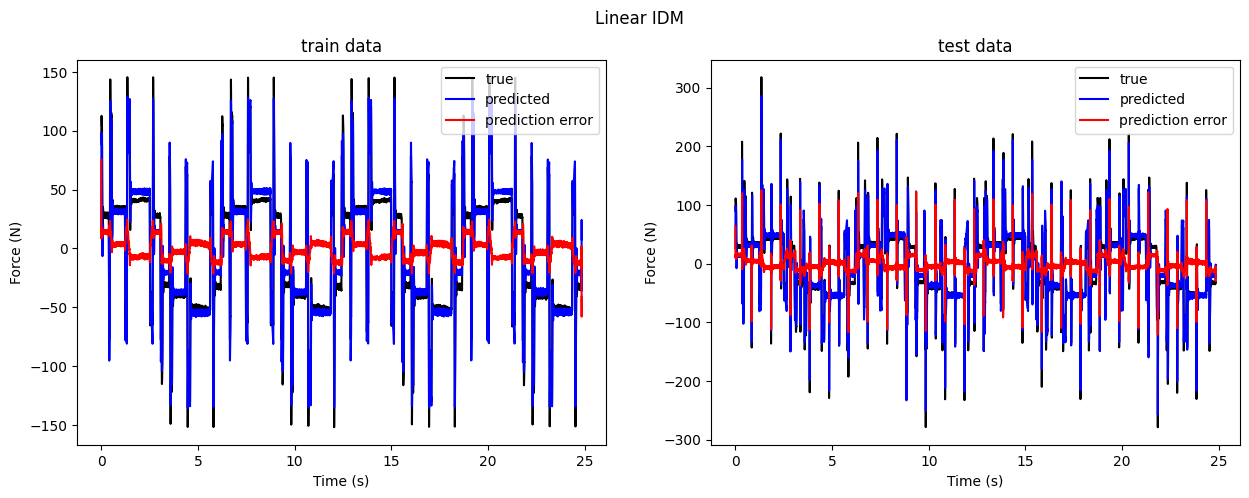

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Linear IDM')
ax[0].plot(train_t, train_y, "k", label='true')
ax[0].plot(train_t, train_y_hat, "b", label='predicted')
ax[0].plot(train_t, train_y - train_y_hat, "r", label='prediction error')
ax[0].legend(loc="upper right")
ax[0].set_title('train data')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Force (N)')

ax[1].plot(test_t, test_y, "k", label='true')
ax[1].plot(test_t, test_y_hat, "b", label='predicted')
ax[1].plot(test_t, test_y - test_y_hat, "r", label='prediction error')
ax[1].legend(loc="upper right")
ax[1].set_title('test data')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Force (N)');

Same in PyTorch (useful only for educational purpose)

In [35]:
# Trining data as pytorch tensors
train_X_torch = torch.tensor(np.c_[train_ddq, train_dq]).float()
train_y_torch = torch.tensor(train_tau).float()

In [36]:
# Linear model in pytorch
friction_lin = nn.Linear(2, 1, bias=True)
friction_lin.weight.data, friction_lin.bias.data

(tensor([[0.5406, 0.5869]]), tensor([-0.1657]))

In [37]:
# Training hyperparameters
iters = 100_000
batch_size = 64
lr = 1e-2

In [38]:
# Train the linear pytorch model

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(friction_lin.parameters(), lr=lr)

LOSS = []
for iter in (pbar := tqdm(range(iters))):
    optimizer.zero_grad()
    batch_idx = np.random.randint(0, len(train_X_torch), batch_size)
    preds = friction_lin(train_X_torch[batch_idx])
    loss = criterion(preds, train_y_torch[batch_idx])
    loss.backward()
    optimizer.step()
    LOSS.append(loss.item())
    if iter % 10000 == 0:
        pbar.set_postfix({'loss': loss.item()})


100%|██████████| 100000/100000 [01:47<00:00, 934.47it/s, loss=76.8]  


In [39]:
friction_lin.weight.data, friction_lin.bias.data # more or less the same as linear least squares

(tensor([[ 95.3627, 411.3774]]), tensor([-3.1387]))

## Linear least-squares IDM with static friction


The linear prediction is not too bad, but it looks somewhat *biased*. Actually, the previous IDM model misses **static friction**, which is relevant in this dataset.

Let us enrich the friction model to:
$$ \tau_{f}(t) = -F_v \dot q(t) - F_c \text{sign}(\dot q(t))$$

We then have:
$$ \tau(t) = M\ddot q(t) + F_v \dot q(t) + F_c \text{sign}(\dot q(t)) + b$$

The IDM with static friction can be modified to:

$$ \tau(t) = \phi(t) \theta, \qquad \phi(t) = [\ddot q(t)\, \dot q(t)\, \text{sign}(q(t))\, 1], \qquad \theta = [M\, F_v\, F_c\, b]^\top,$$

which can still be treated as a linear regression adding the feature $\text{sign}(q(t))$. In machine-learning terms, we are doing *feature engineering*.

In [40]:
train_X_feat = np.c_[train_ddq, train_dq, np.sign(train_dq)]
test_X_feat = np.c_[test_ddq, test_dq, np.sign(train_dq)]

In [41]:
lin_feat = sklearn.linear_model.LinearRegression().fit(train_X_feat, train_y)
lin_feat.coef_, lin_feat.intercept_

(array([[ 95.07423149, 204.29921873,  20.32136663]]), array([-3.17102298]))

In [42]:
train_y_hat = lin_feat.predict(train_X_feat)
train_rmse = np.sqrt(np.mean((train_y - train_y_hat)**2))
#test_y_hat = test_X @ theta_ls
test_y_hat = lin_feat.predict(test_X_feat)
test_rmse = np.sqrt(np.mean((test_y - test_y_hat)**2))
train_rmse, test_rmse

(2.494115604995232, 6.506140130166829)

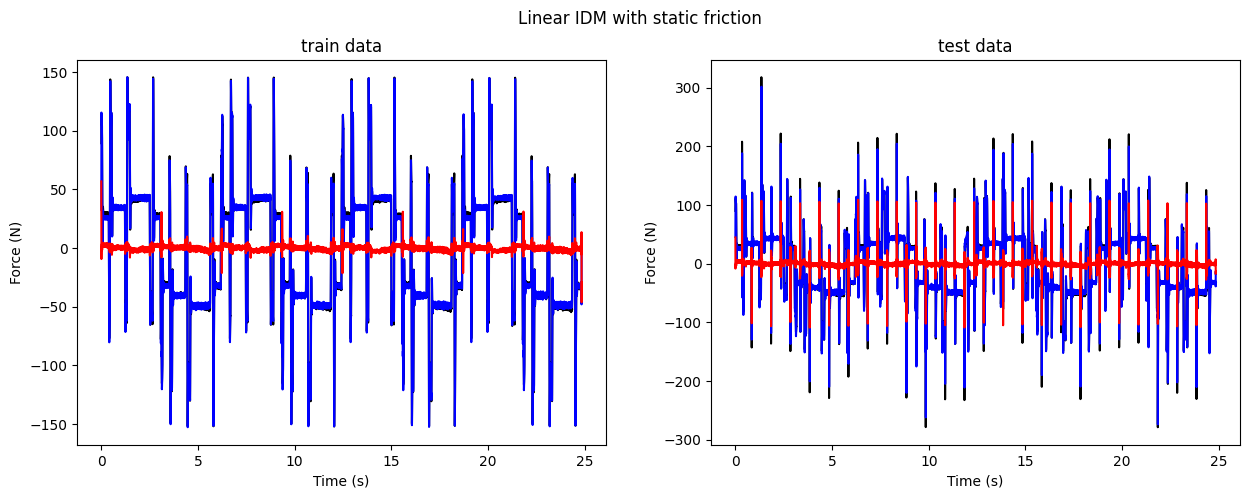

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Linear IDM with static friction')
ax[0].plot(train_t, train_y, "k", label='true')
ax[0].plot(train_t, train_y_hat, "b", label='predicted')
ax[0].plot(train_t, train_y - train_y_hat, "r", label='prediction error')
ax[0].set_title('train data')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Force (N)')

ax[1].plot(test_t, test_y, "k", label='true')
ax[1].plot(test_t, test_y_hat, "b", label='predicted')
ax[1].plot(test_t, test_y - test_y_hat, "r", label='prediction error')
ax[1].set_title('test data')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Force (N)');

Train and test performance significantly improved, force estimation qualitatively much better! However, it requires some knowldege.
What if we didn't know about static friction? What if the previous model is still not enough?

# Feed-forward neural network IDM

What if we didn't know about static friction? What if the true torque model is even more complex?

We may fit a neural-netwok IDM!

$$ \tau(t) = \mathrm{FF}(\ddot q, \dot q) $$


  0%|          | 4/10000 [00:00<07:34, 21.98it/s]

Epoch 0, Loss: 2927.517578125


 10%|█         | 1017/10000 [00:12<01:41, 88.91it/s]

Epoch 1000, Loss: 584.5025024414062


 20%|██        | 2012/10000 [00:23<01:30, 88.56it/s]

Epoch 2000, Loss: 259.8371887207031


 30%|███       | 3013/10000 [00:34<01:21, 86.00it/s]

Epoch 3000, Loss: 91.87338256835938


 40%|████      | 4011/10000 [00:46<01:13, 81.46it/s]

Epoch 4000, Loss: 29.552156448364258


 50%|█████     | 5010/10000 [01:04<01:47, 46.44it/s]

Epoch 5000, Loss: 11.88408374786377


 60%|██████    | 6005/10000 [01:22<01:16, 52.42it/s]

Epoch 6000, Loss: 6.377994537353516


 70%|███████   | 7011/10000 [01:40<00:54, 54.38it/s]

Epoch 7000, Loss: 3.8448123931884766


 80%|████████  | 8005/10000 [01:59<00:38, 51.80it/s]

Epoch 8000, Loss: 2.2618565559387207


 90%|█████████ | 9008/10000 [02:17<00:19, 51.68it/s]

Epoch 9000, Loss: 2.0539798736572266


100%|██████████| 10000/10000 [02:35<00:00, 64.13it/s]


Epoch 9999, Final Loss: 1.761694073677063


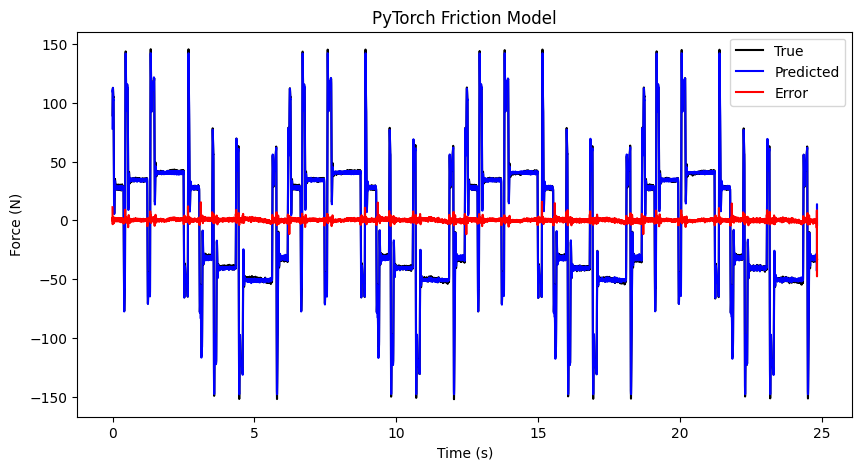

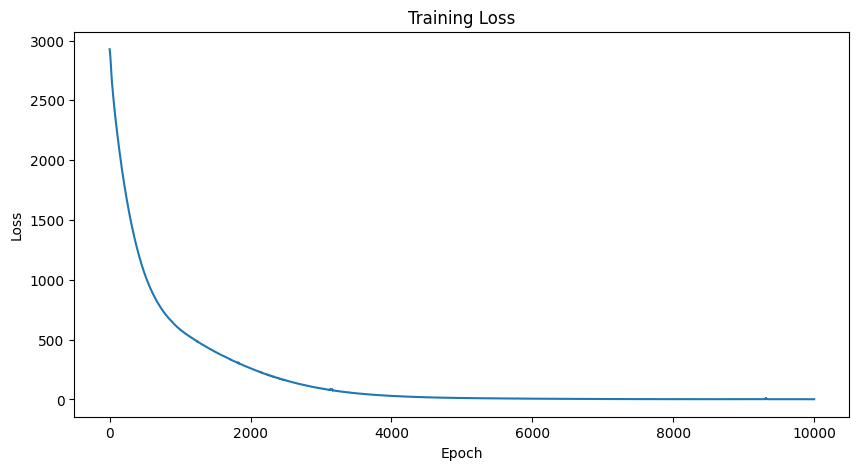

In [61]:
class FrictionModel(nn.Module):
    def __init__(self):
        super(FrictionModel, self).__init__()
        self.input = nn.Linear(2, 32)
        self.acti = nn.Tanh()
        self.layer1 = nn.Linear(32, 20)
        self.act1 = nn.Tanh()
        self.layer2 = nn.Linear(20, 10)
        self.act2 = nn.Tanh()
        self.layer3 = nn.Linear(10, 6)
        self.act3 = nn.Tanh()   
        self.output = nn.Linear(6, 1)
        
    def forward(self, x):
        x = self.input(x)
        x = self.acti(x)
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.layer3(x)
        x = self.act3(x)
        x = self.output(x)
        return x   
    


# Data conversion in versors for PyTorch
train_X_ddq_dq = np.c_[train_ddq, train_dq]
train_X_feat_torch = torch.tensor(train_X_ddq_dq).float()
train_y_torch = torch.tensor(train_tau).float()

# Model definition
friction_model = FrictionModel()
optimizer = torch.optim.Adam(friction_model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

# Training loop
epochs = 10000
LOSS = []

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    predictions = friction_model(train_X_feat_torch)
    loss = criterion(predictions, train_y_torch)
    loss.backward()
    optimizer.step()
    LOSS.append(loss.item())
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    if epoch == epochs-1:
        print(f'Epoch {epoch}, Final Loss: {loss.item()}')

# Model evaluation
train_y_hat_torch = friction_model(train_X_feat_torch).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(train_t, train_y, "k", label='True')
plt.plot(train_t, train_y_hat_torch, "b", label='Predicted')
plt.plot(train_t, train_y - train_y_hat_torch, "r", label='Error')
plt.legend()
plt.title("PyTorch Friction Model")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(LOSS)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


## Physics-inspired neural network

What if we trust Newton, but we want some flexibility for / we are ignorant about friction? We can design a custom grey-box model!

$$\tau(t) = M \ddot q + \mathrm{FF}(\dot q)$$

Linear in $\ddot q$, non-linear in $\dot q$